## Notes and resources

https://quantum.cloud.ibm.com/ = dashboard for the IBM Quantum Cloud


Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install `)
* Qiskit Runtime 0.22 or later (`pip install `)


In [1]:
# autoreload
%load_ext autoreload
%autoreload 2


## Setup


In [52]:
# Qiskit imports
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer, AerSimulator
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit.transpiler import Layout
from qiskit import QuantumCircuit, transpile
# tutorial at https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/error-correction-repetition-code.ipynb
from mldec.hardware.topological_codes.circuits import RepetitionCode, HardwarePhaseFlipRepetitionCode
from mldec.hardware.topological_codes.fitters import GraphDecoder, lookuptable_decoding

# circuit wrappers and optimizers
from mldec.hardware.topological_codes.wrappers import insert_idle_delays
from mldec.hardware.topological_codes.noise import get_noise

import numpy as np

from qiskit_ibm_runtime.fake_provider import (FakeAlgiers, FakeAthensV2, FakeBelemV2, FakeManilaV2,
                                            FakeAuckland, FakeBrisbane, FakeOsaka, FakeKyoto)
fake_backends = [FakeAlgiers(), FakeAthensV2(), FakeBelemV2(), FakeManilaV2(), FakeAuckland(),
                FakeBrisbane(), FakeOsaka(), FakeKyoto()] 
from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit_experiments.framework import BackendTiming, BaseExperiment, Options


#### Specify the backend/provider, in order to build a hardware-aware circuit

In [3]:
service = QiskitRuntimeService()
# backend = service.least_busy(simulator=False, operational=True, min_num_qubits=5)
real_backend = service.backend('ibm_torino')
fake_backend = FakeTorino()

sim_backend = AerSimulator.from_backend(fake_backend)

### my code

This code seems to actually work and apply thermal relaxation to the delay gates.

In [91]:
timing.delay_unit

'dt'

In [93]:
help(circ.delay)

Help on method delay in module qiskit.circuit.quantumcircuit:

delay(duration: 'Union[ParameterValueType, expr.Expr]', qarg: 'QubitSpecifier | None' = None, unit: 'str | None' = None) -> 'InstructionSet' method of qiskit.circuit.quantumcircuit.QuantumCircuit instance
    Apply :class:`~.circuit.Delay`. If qarg is ``None``, applies to all qubits.
    When applying to multiple qubits, delays with the same duration will be created.
    
    Args:
        duration (Object):
            duration of the delay. If this is an :class:`~.expr.Expr`, it must be
            a constant expression of type :class:`~.types.Duration`.
        qarg (Object): qubit argument to apply this delay.
        unit (str | None): unit of the duration, unless ``duration`` is an :class:`~.expr.Expr`
            in which case it must not be specified. Supported units: ``'s'``, ``'ms'``, ``'us'``,
            ``'ns'``, ``'ps'``, and ``'dt'``. Default is ``'dt'``, i.e. integer time unit
            depending on the ta

In [96]:
help(timing.round_delay)

Help on method round_delay in module qiskit_experiments.framework.backend_timing:

round_delay(*, time: Optional[float] = None, samples: Union[int, float, NoneType] = None) -> Union[int, float] method of qiskit_experiments.framework.backend_timing.BackendTiming instance
    Delay duration closest to input and consistent with timing constraints
    
    This method produces the value to pass for the ``duration`` of a
    ``Delay`` instruction of a ``QuantumCircuit`` so that the delay fills
    the time until the next valid pulse, assuming the ``Delay`` instruction
    begins on a sample that is also valid for a pulse to begin on.
    
    The pulse timing constraints of the backend are considered in order to
    give the number of samples closest to the input (either ``time`` or
    ``samples``) for the start of a pulse in a subsequent instruction to be
    valid. The delay value in samples is rounded to the least common
    multiple of the pulse and acquire alignment values in order to

In [95]:
# A T1 simulator
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import numpy as np
import qiskit

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

sampler = Sampler(backend)
qubit = 0
# set the desired delays
delays = list(np.arange(1e-6, 50e-6, 2e-6))

timing = BackendTiming(backend)


run_options = {'shots': 2000, 'seed_simulator': 101}
transpile_options = {'scheduling_method': 'asap', 'optimization_level': 0}

circuits = []
rotation_angle = np.pi/3
for delay_factor in delays:
    circ = qiskit.QuantumCircuit(1, 1)
    circ.sx(0)  # Brings the qubit to the X Axis
    print(timing.round_delay(time=delay_factor))
    circ.delay(timing.round_delay(time=delay_factor), 0, timing.delay_unit)
    # circ.rz(rotation_angle, 0)
    circ.barrier(0)
    circ.sx(0)
    circ.barrier(0)
    circ.measure(0, 0)
    display(circ.draw(fold=999))
    circuits.append(circ)

# CRITICAL FIX: Transpile circuits with scheduling and run the transpiled circuits
transpiled = transpile(circuits, backend, scheduling_method='asap')
# sampler.options.simulator.noise_model = noise_model
# Run the transpiled circuits, not the original ones!
jobs = sampler.run(transpiled, shots=2000)

4496


┌────┐┌─────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(4496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└─────────────────┘ ░ └────┘ ░ └╥┘
c: 1/══════════════════════════════════════╩═
                                           0

13504


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(13504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

22496


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(22496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

31504


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(31504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

40496


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(40496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

49504


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(49504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

58496


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(58496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

67504


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(67504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

76496


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(76496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

85504


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(85504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

94496


┌────┐┌──────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(94496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└──────────────────┘ ░ └────┘ ░ └╥┘
c: 1/═══════════════════════════════════════╩═
                                            0

103504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(103504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

112496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(112496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

121504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(121504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

130496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(130496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

139504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(139504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

148496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(148496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

157504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(157504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

166496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(166496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

175504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(175504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

184496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(184496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

193504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(193504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

202496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(202496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

211504


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(211504[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

220496


┌────┐┌───────────────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(220496[dt]) ├─░─┤ √X ├─░─┤M├
     └────┘└───────────────────┘ ░ └────┘ ░ └╥┘
c: 1/════════════════════════════════════════╩═
                                             0

In [92]:
for i, job_result in enumerate(jobs.result()):
    results = job_result.data.c.get_counts()
    print(delays[i], results['0'], results['1'])
    # print(i, results)

1e-06 3 1997
3e-06 21 1979
5e-06 22 1978
7.000000000000001e-06 32 1968
9.000000000000002e-06 44 1956
1.1000000000000003e-05 55 1945
1.3000000000000003e-05 61 1939
1.5000000000000002e-05 78 1922
1.7000000000000003e-05 71 1929
1.9000000000000004e-05 95 1905
2.1000000000000006e-05 88 1912
2.3000000000000003e-05 84 1916
2.5000000000000005e-05 120 1880
2.7000000000000006e-05 120 1880
2.9000000000000004e-05 121 1879
3.1e-05 139 1861
3.3e-05 126 1874
3.5000000000000004e-05 153 1847
3.7000000000000005e-05 151 1849
3.9000000000000006e-05 152 1848
4.100000000000001e-05 176 1824
4.3e-05 172 1828
4.5e-05 197 1803
4.7000000000000004e-05 220 1780
4.9000000000000005e-05 196 1804


In [ ]:
# A T1 simulator
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp1.set_transpile_options(scheduling_method='asap')

# Run experiment
expdata1 = exp1.run(backend=backend, shots=2000, seed_simulator=101)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

### Ramsey experiment i want to reverse-engineer

In [50]:
from qiskit_experiments.library import T2Ramsey
# A T1 simulator
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel


qubit = 0
# set the desired delays
delays = list(np.arange(1e-6, 50e-6, 2e-6))

# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Ramsey((qubit,), delays, osc_freq=1e5)

print(exp1.circuits()[0])

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp1.set_transpile_options(scheduling_method='asap')

# Run experiment
expdata1 = exp1.run(backend=backend, shots=2000, seed_simulator=101)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

     ┌────┐┌─────────────────┐┌─────────┐ ░ ┌────┐ ░ ┌─┐
  q: ┤ √X ├┤ Delay(1e-06[s]) ├┤ Rz(π/5) ├─░─┤ √X ├─░─┤M├
     └────┘└─────────────────┘└─────────┘ ░ └────┘ ░ └╥┘
c: 1/═════════════════════════════════════════════════╩═
                                                      0 


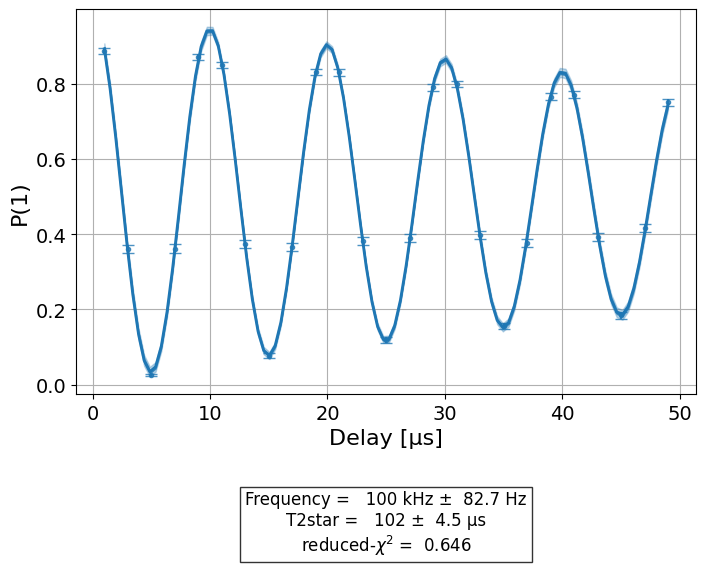

In [ ]:

delay_factors = [1, 10, 100, 1e4, 1e5, 1e6]
timing = BackendTiming(backend)
circuits = []
rotation_angle = np.pi/3
for delay_factor in delay_factors:
    circ = qiskit.QuantumCircuit(1, 1)
    circ.sx(0)  # Brings the qubit to the X Axis
    circ.delay(timing.round_delay(time=delay_factor), 0, unit='us')
    # circ.rz(rotation_angle, 0)
    circ.barrier(0)
    circ.sx(0)
    circ.barrier(0)
    circ.measure(0, 0)
    display(circ.draw(fold=999))
    circuits.append(circ)

# CRITICAL FIX: Transpile circuits with scheduling and run the transpiled circuits
transpiled = transpile(circuits, backend, scheduling_method='asap')
sampler.options.simulator.noise_model = noise_model
# Run the transpiled circuits, not the original ones!
jobs = sampler.run(transpiled, shots=2000)